### These are all the columns that we are going to work with in this project

obj_ID: Object Identifier, the unique value that identifies the object in the image catalog used by the CAS

alpha: Right Ascension angle (at J2000 epoch)

delta: Declination angle (at J2000 epoch)

u: Ultraviolet filter in the photometric system

g: Green filter in the photometric system

r: Red filter in the photometric system

i: Near Infrared filter in the photometric system

z: Infrared filter in the photometric system

run_ID: Run Number used to identify the specific scan

rereun_ID: Rerun Number to specify how the image was processed

cam_col: Camera column to identify the scanline within the run

field_ID: Field number to identify each field

spec_obj_ID: Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)

class: object class (galaxy, star or quasar object)

redshift: redshift value based on the increase in wavelength

plate: plate ID, identifies each plate in SDSS

MJD: Modified Julian Date, used to indicate when a given piece of SDSS data was taken

fiber_ID: fiber ID that identifies the fiber that pointed the light at the focal plane in each observation

# Importing the data

In [4]:
import pandas as pd
pd.DataFrame.iteritems = pd.DataFrame.items
from scipy.stats import randint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score

In [5]:
start = time.time()

In [6]:
df = pd.read_csv('star_classification.csv')

In [7]:
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

In [9]:
df.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.237665e+18,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,4481.366060,301.0,3.511610,186.130520,5.783882e+18,0.576661,5137.009660,55588.647500,449.312740
std,8.438560e+12,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,1964.764593,0.0,1.586912,149.011073,3.324016e+18,0.730707,2952.303351,1808.484233,272.498404
min,1.237646e+18,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,301.0,1.000000,11.000000,2.995191e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,3187.000000,301.0,2.000000,82.000000,2.844138e+18,0.054517,2526.000000,54234.000000,221.000000
50%,1.237663e+18,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,4188.000000,301.0,4.000000,146.000000,5.614883e+18,0.424173,4987.000000,55868.500000,433.000000
75%,1.237668e+18,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,5326.000000,301.0,5.000000,241.000000,8.332144e+18,0.704154,7400.250000,56777.000000,645.000000
max,1.237681e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


# EDA

In [11]:
x1 = df.drop('class', axis = 1)

In [12]:
x1.corr()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
obj_ID,1.000000,-0.013735,-0.301237,0.015310,0.015710,0.153891,0.147670,0.013811,1.000000,NaN,-0.046997,0.031498,0.239461,0.065400,0.239460,0.262687,0.067178
alpha,-0.013735,1.000000,0.138691,-0.001532,-0.002423,-0.022083,-0.023580,-0.002918,-0.013737,NaN,0.019582,-0.165577,-0.002553,0.001667,-0.002554,0.019943,0.030464
delta,-0.301237,0.138691,1.000000,0.002074,0.003523,-0.006835,-0.004480,0.003630,-0.301238,NaN,0.032565,-0.173416,0.112329,0.031638,0.112329,0.107333,0.028250
u,0.015310,-0.001532,0.002074,1.000000,0.999311,0.054149,0.045730,0.998093,0.015309,NaN,0.003548,-0.008374,0.029997,0.014309,0.029997,0.031997,0.016305
g,0.015710,-0.002423,0.003523,0.999311,1.000000,0.062387,0.056271,0.999161,0.015710,NaN,0.003508,-0.008852,0.039443,0.022954,0.039443,0.040274,0.017470
r,0.153891,-0.022083,-0.006835,0.054149,0.062387,1.000000,0.962868,0.053677,0.153889,NaN,0.008480,-0.026423,0.655245,0.433241,0.655243,0.671180,0.223106
i,0.147670,-0.023580,-0.004480,0.045730,0.056271,0.962868,1.000000,0.055994,0.147668,NaN,0.007615,-0.026679,0.661641,0.492383,0.661640,0.672523,0.214787
z,0.013811,-0.002918,0.003630,0.998093,0.999161,0.053677,0.055994,1.000000,0.013811,NaN,0.003365,-0.008903,0.037813,0.030380,0.037813,0.037469,0.014668
run_ID,1.000000,-0.013737,-0.301238,0.015309,0.015710,0.153889,0.147668,0.013811,1.000000,NaN,-0.047098,0.031498,0.239460,0.065400,0.239459,0.262687,0.067165
rerun_ID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df.rename(columns = {'alpha': 'Right Ascension Angle', 'delta': 'Declination Angle', 'u': 'Ultraviolet Filter',
                      'g': 'Green Filter', 'r': 'Red Filter', 'i': 'Near Infrared Filter', 'z': 'Infrared Filter',
                      'cam_col': 'Camera Column', 'class': 'Class', 'redshift': 'Redshift'},
            inplace = True)

In [14]:
df.drop(columns = ['obj_ID', 'run_ID', 'rerun_ID', 'field_ID', 'spec_obj_ID', 'plate', 'MJD', 'fiber_ID'], inplace = True)

In [15]:
df.head()

,Right Ascension Angle,Declination Angle,Ultraviolet Filter,Green Filter,Red Filter,Near Infrared Filter,Infrared Filter,Camera Column,Class,Redshift
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,2,GALAXY,0.634794
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,5,GALAXY,0.779136
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,2,GALAXY,0.644195
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,3,GALAXY,0.932346
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,3,GALAXY,0.116123


In [16]:
df['Class'].unique()

array(['GALAXY', 'QSO', 'STAR'], dtype=object)

In [17]:
df['Class'].value_counts()

Class
GALAXY    59445
STAR      21594
QSO       18961
Name: count, dtype: int64

In [18]:
features = ['Right Ascension Angle', 'Declination Angle', 'Ultraviolet Filter',
            'Green Filter', 'Red Filter', 'Near Infrared Filter', 'Infrared Filter',
            'Camera Column', 'Redshift']

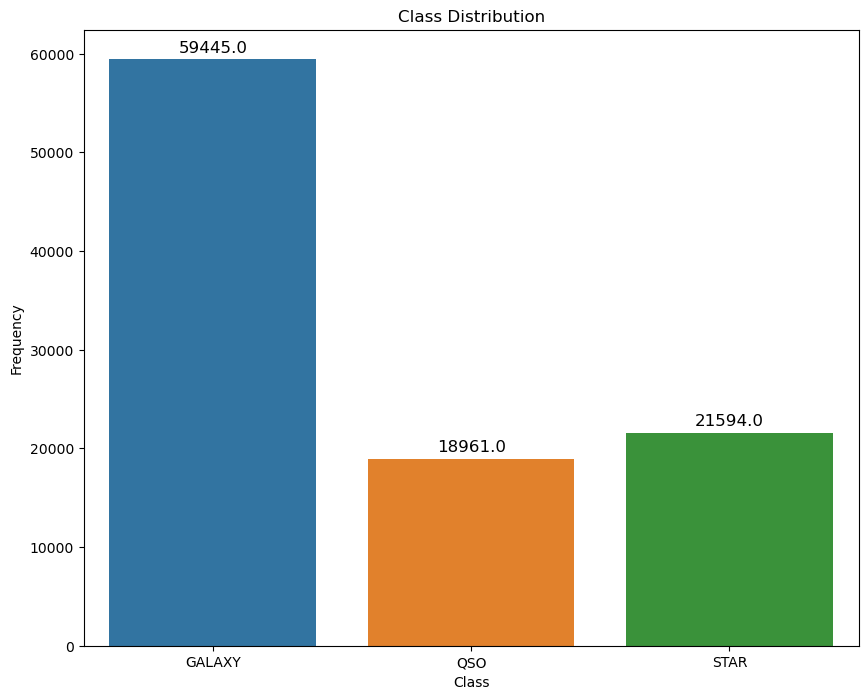

In [19]:
plt.figure(figsize=(10, 8))
ax = sns.countplot(data=df, x='Class', hue= 'Class')  # replace 'class' with your actual target column name
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')

# Add count labels on each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

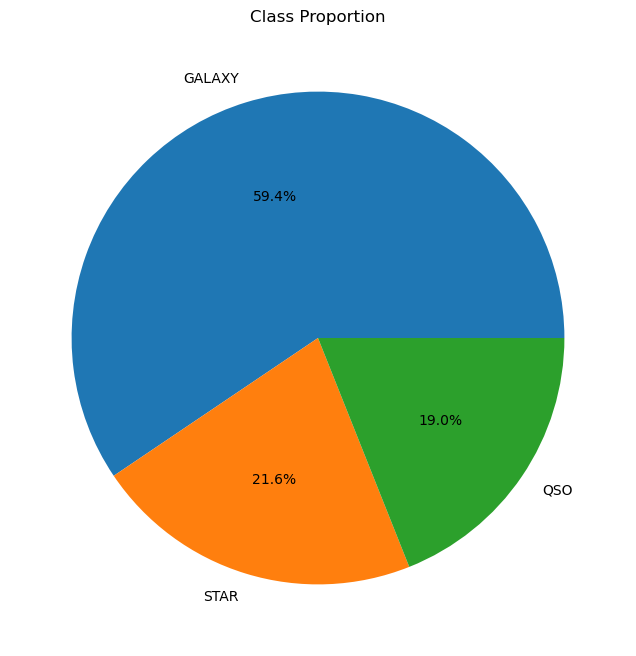

In [20]:
plt.figure(figsize=(8, 8))
class_counts = df['Class'].value_counts()
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%')
plt.title('Class Proportion')
plt.ylabel('')
plt.show()

In [21]:
df.isnull().sum()

Right Ascension Angle    0
Declination Angle        0
Ultraviolet Filter       0
Green Filter             0
Red Filter               0
Near Infrared Filter     0
Infrared Filter          0
Camera Column            0
Class                    0
Redshift                 0
dtype: int64

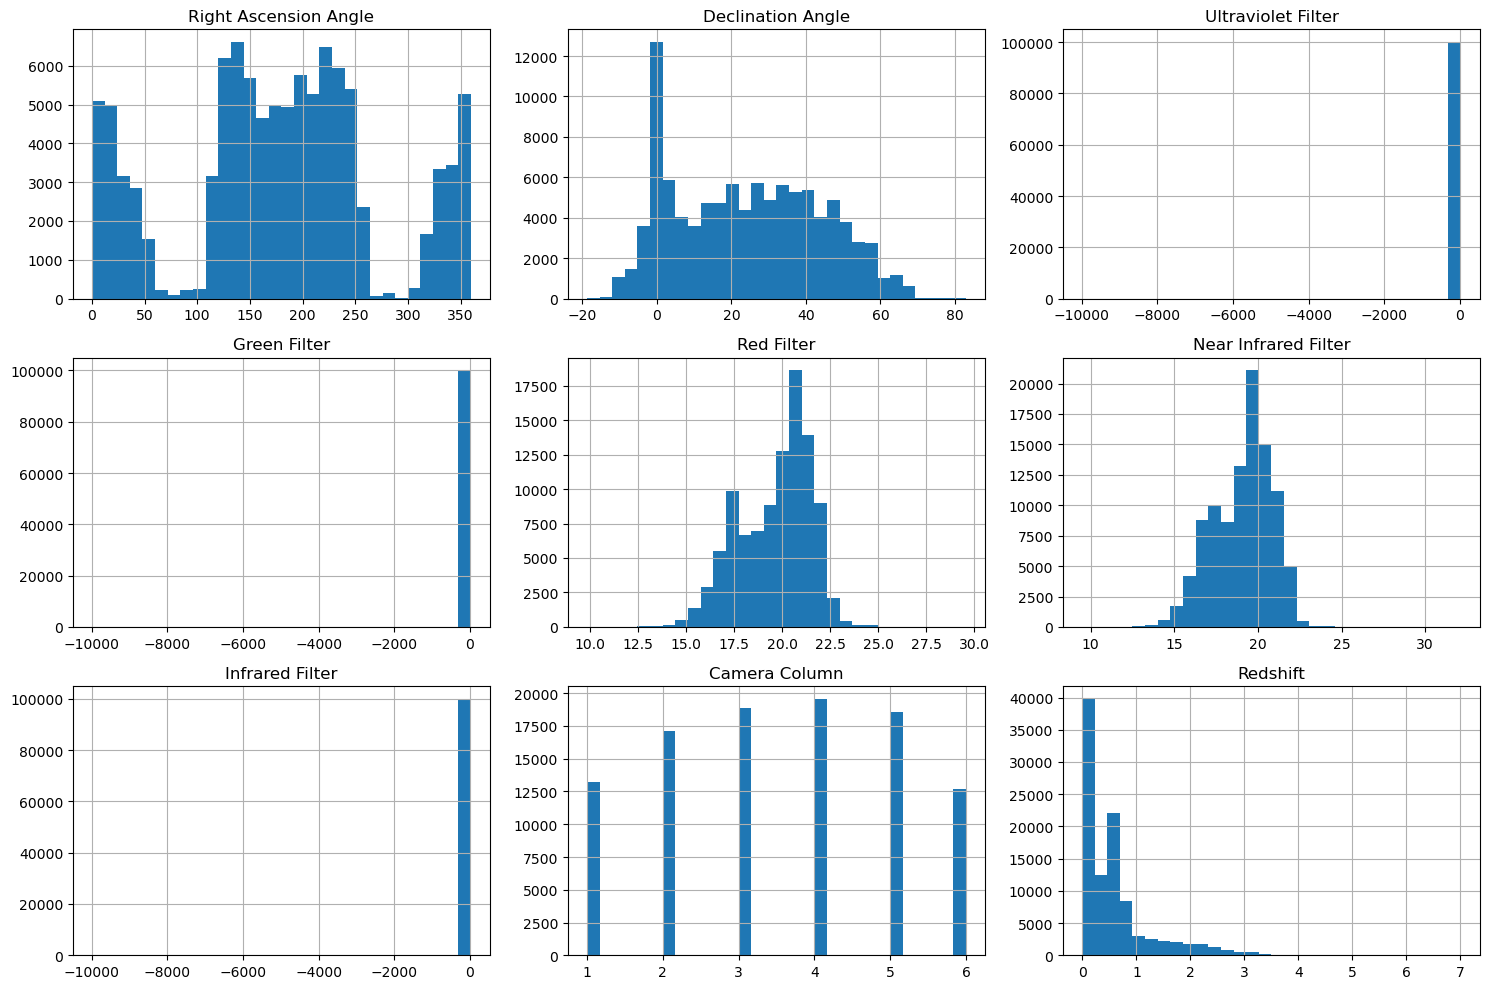

In [22]:
df.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

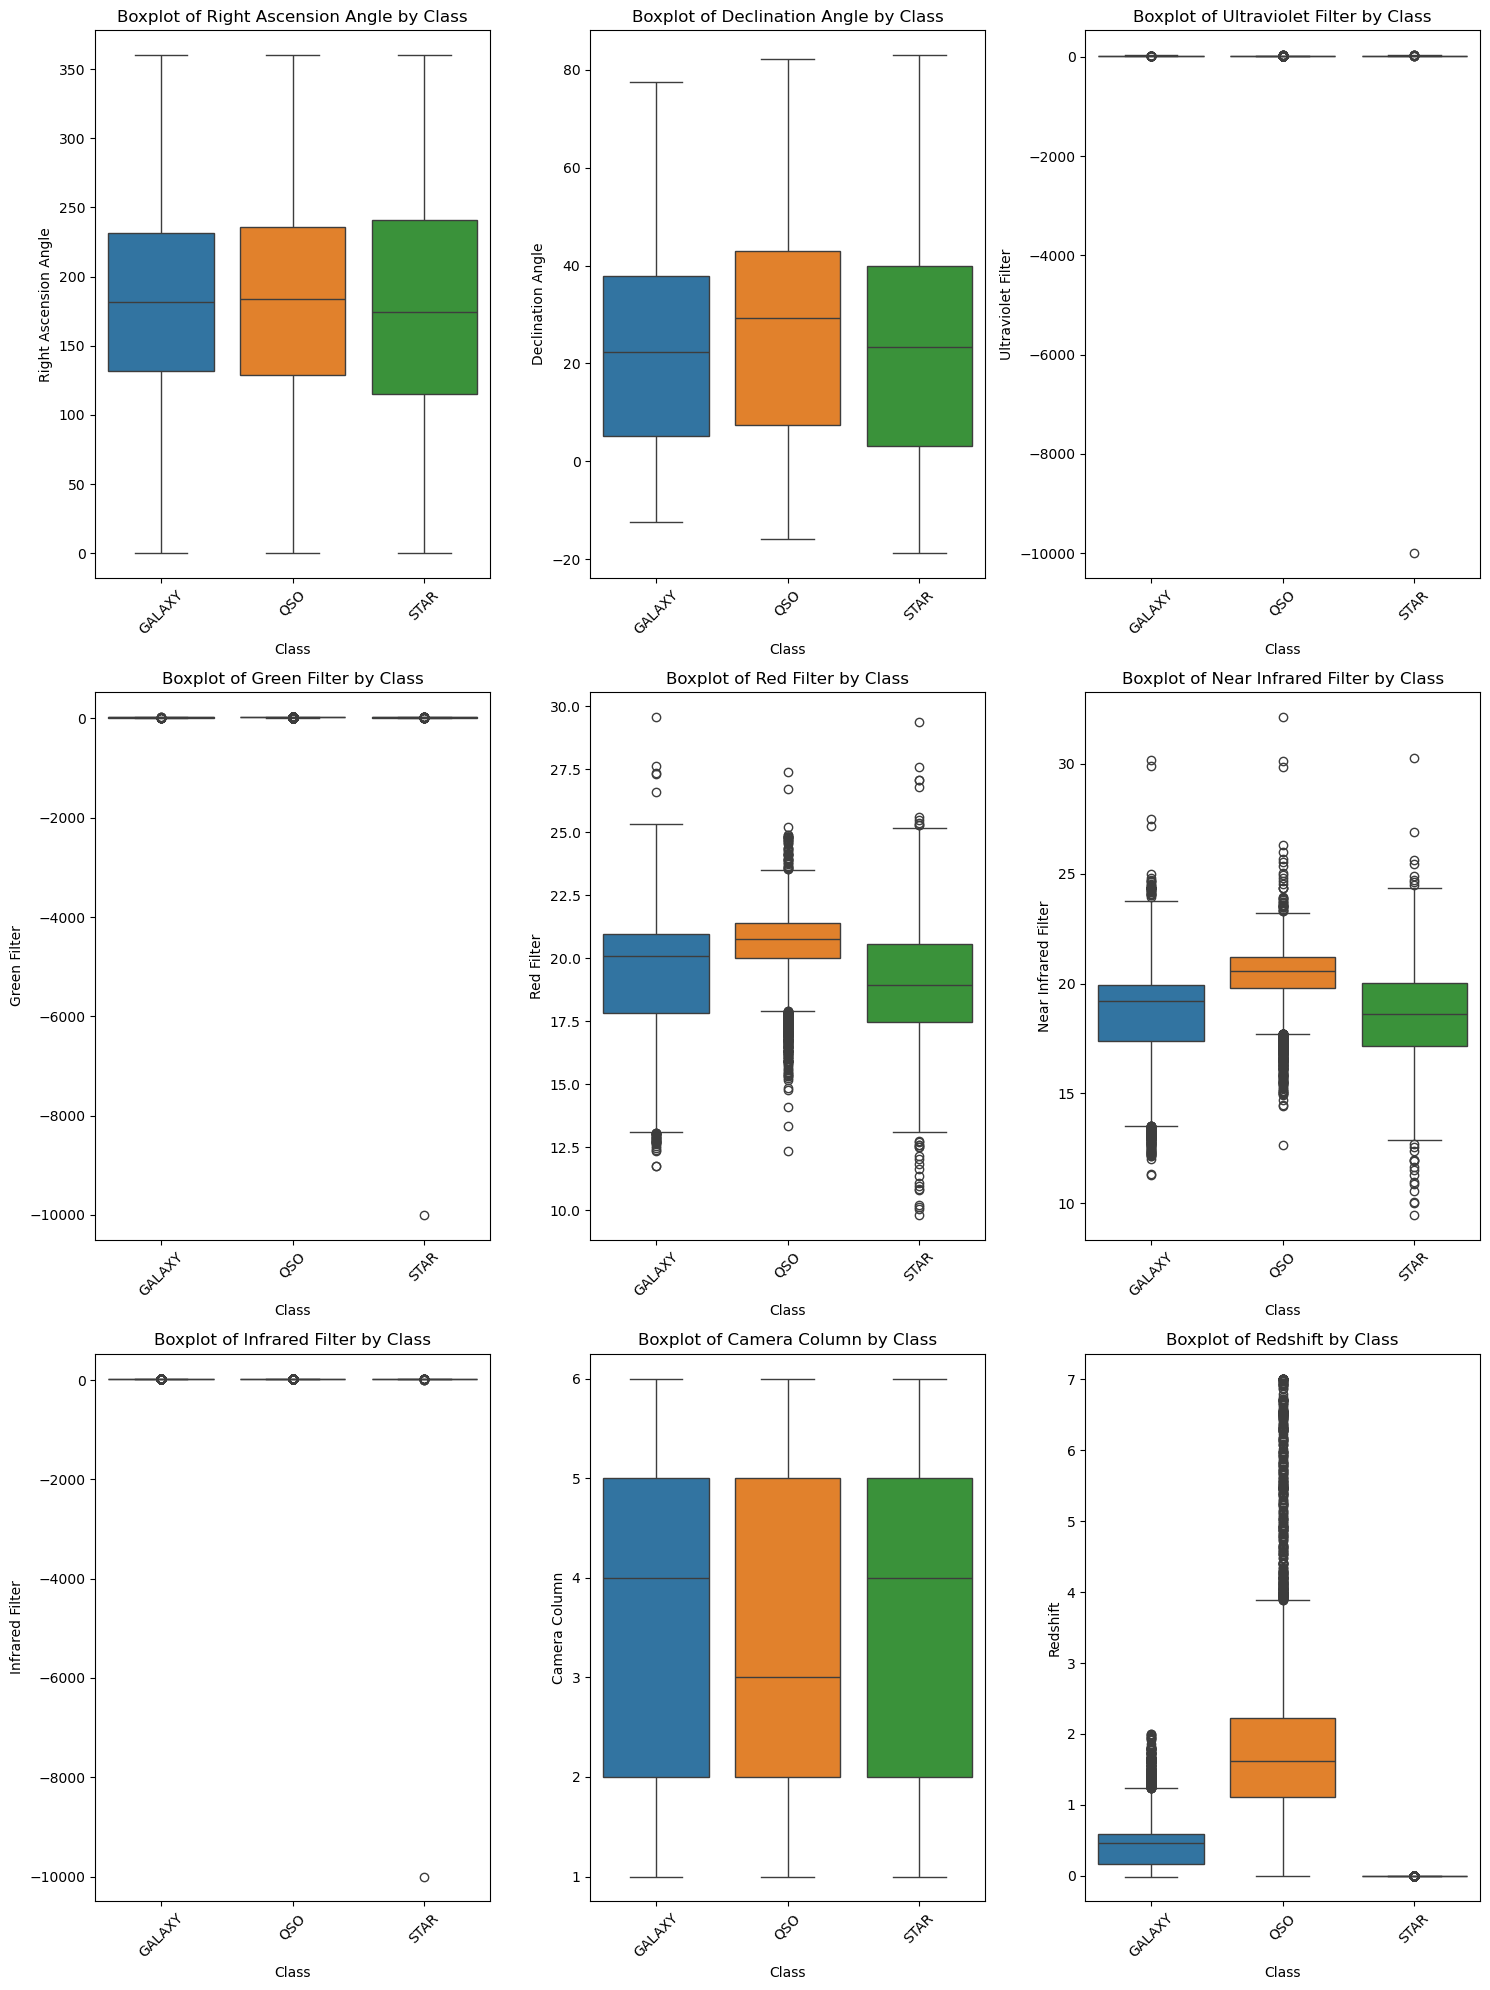

In [23]:
# Set the size of the plot
plt.figure(figsize=(15, 20))

# Loop through each feature and plot a boxplot
for i, feature in enumerate(features, start=1):
    plt.subplot(3, 3, i)  # Create a 3x3 grid of plots
    sns.boxplot(data=df, x='Class', y=feature, hue='Class')  # Replace 'class' with your actual target column name
    plt.title(f'Boxplot of {feature} by Class')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

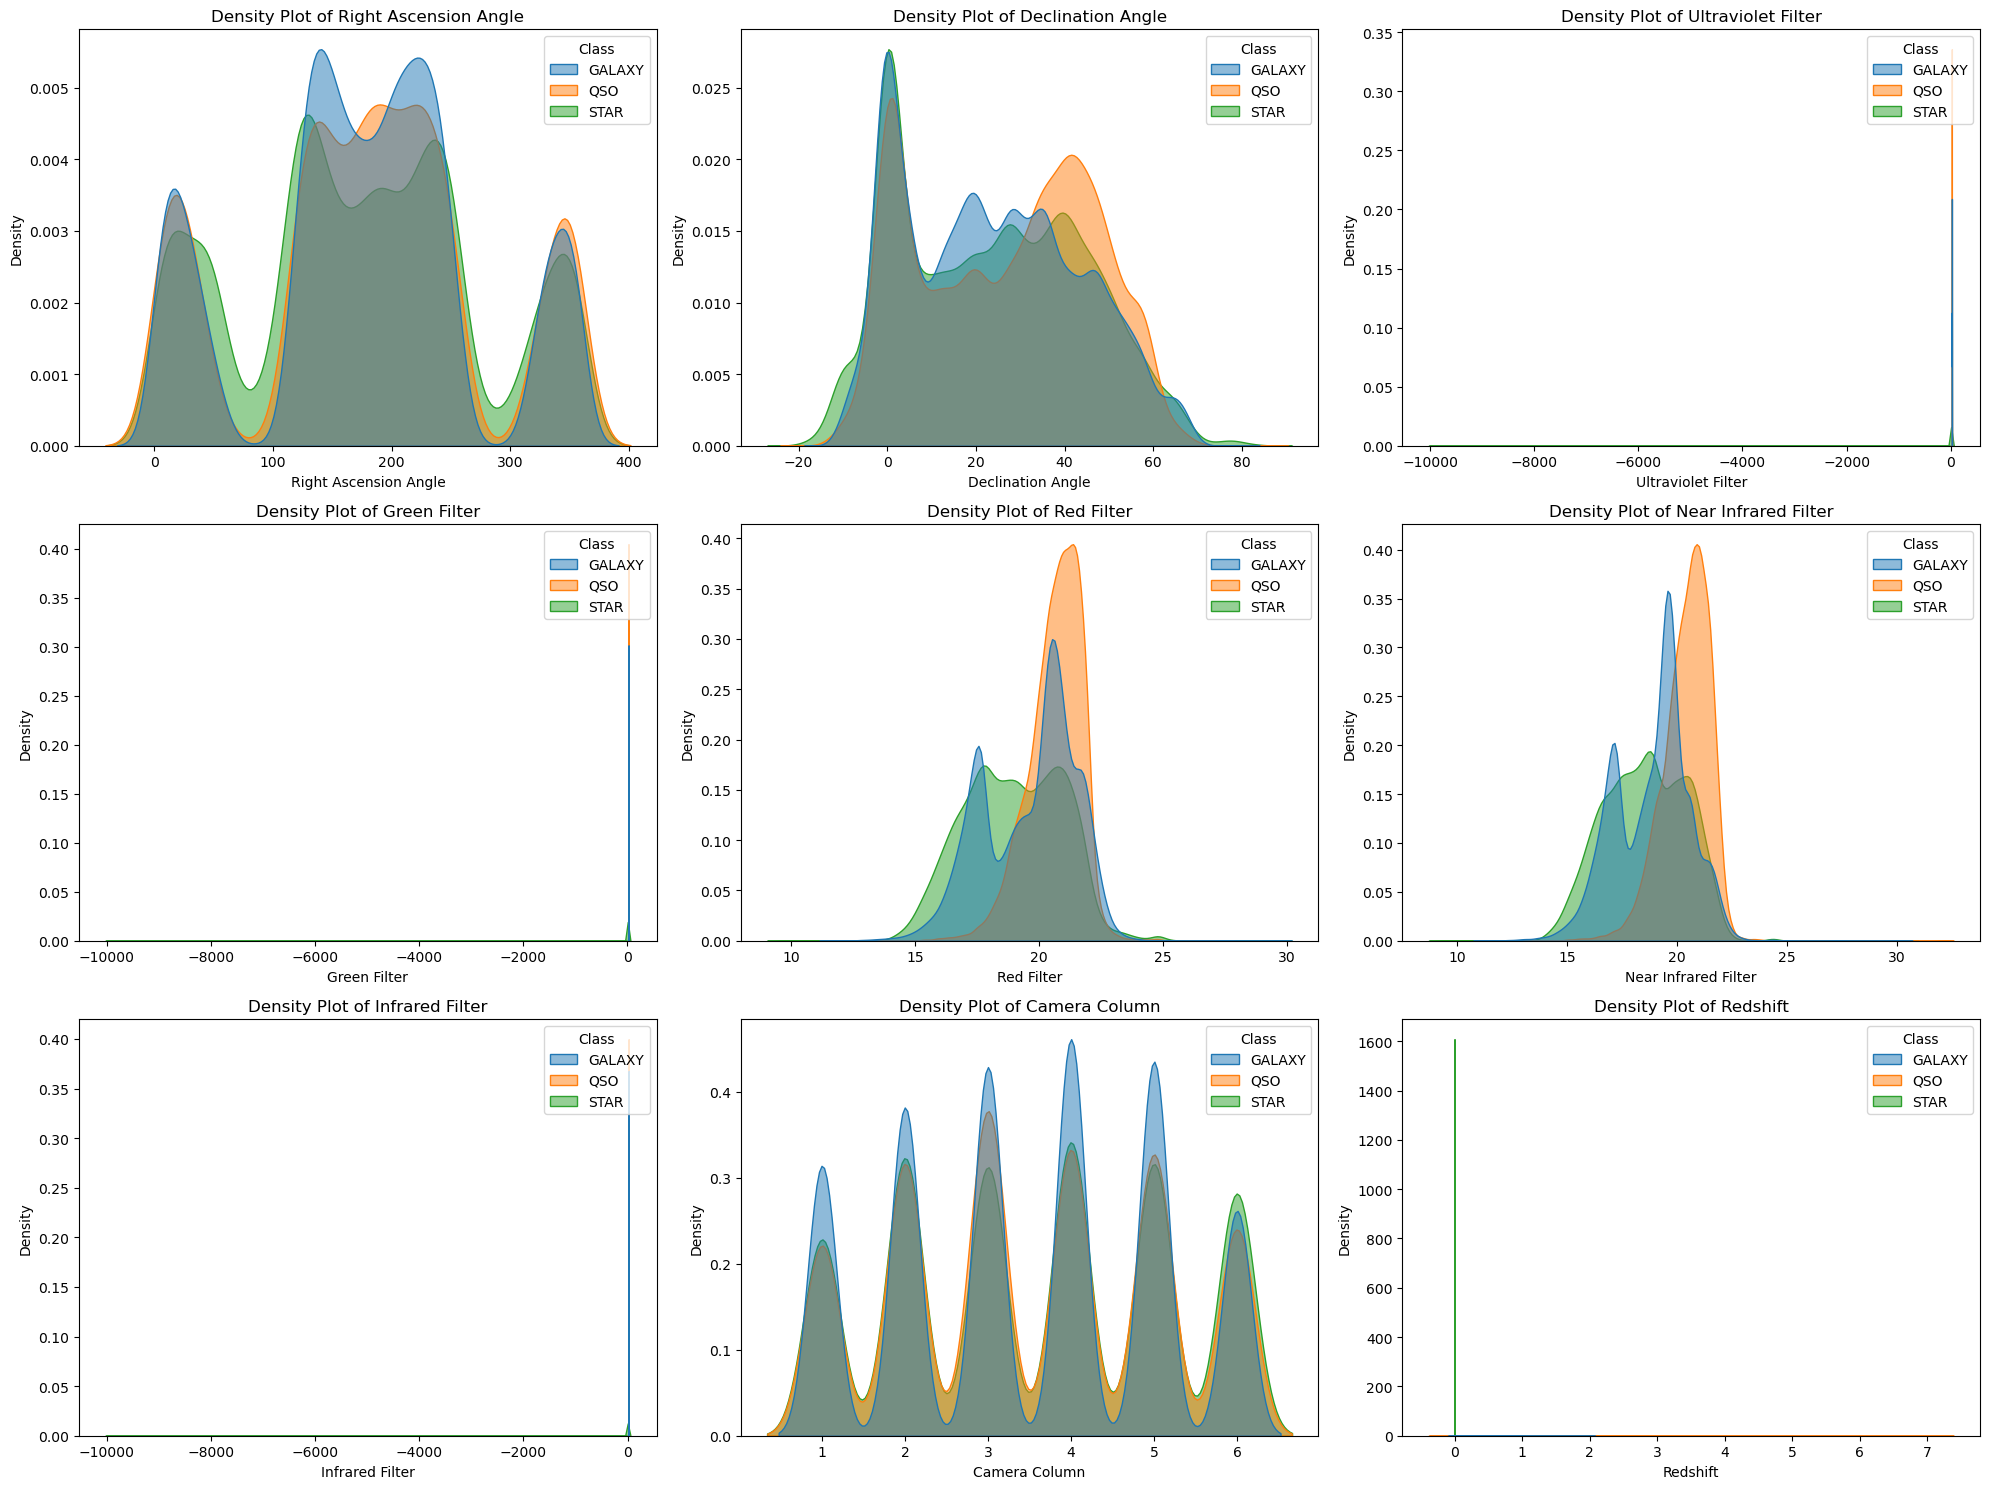

In [24]:
plt.figure(figsize=(20, 15))

# Loop through each feature and plot a density plot
for i, feature in enumerate(features, start=1):
    plt.subplot(3, 3, i)  # Create a 3x3 grid of plots
    sns.kdeplot(data=df, x=feature, hue='Class', common_norm=False, fill=True, alpha=0.5)  # Replace 'class' with your actual target column name
    plt.title(f'Density Plot of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [25]:
df['Class'] = LabelEncoder().fit_transform(df['Class'])

In [26]:
x = df.drop('Class', axis = 1)
y = df['Class']

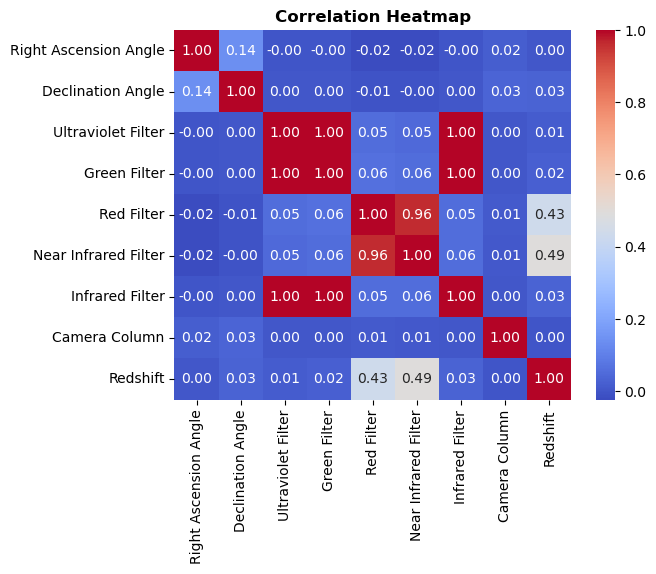

In [27]:
sns.heatmap(x.corr(), annot = True, fmt = '.2f',  cmap = "coolwarm")
plt.title('Correlation Heatmap', weight = 'bold')
plt.show()

# Data Standardization

In [29]:
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

In [30]:
df.head()

,Right Ascension Angle,Declination Angle,Ultraviolet Filter,Green Filter,Red Filter,Near Infrared Filter,Infrared Filter,Camera Column,Class,Redshift
0,-0.434604,0.425529,0.059755,0.054926,0.403962,0.046007,0.003937,-0.952553,0,0.079557
1,-0.339921,0.363402,0.088045,0.072456,1.584406,1.185097,0.092835,0.937920,0,0.277096
2,-0.367251,0.582713,0.103327,0.067165,0.519745,0.150019,0.008808,-0.952553,0,0.092423
3,1.669523,-1.249105,0.004921,0.102210,1.059904,0.807610,0.018321,-0.322395,0,0.486770
4,1.737310,-0.150242,-0.080055,-0.092948,-1.697421,-1.767887,-0.098468,-0.322395,0,-0.630267


In [31]:
df['Class'].unique()

array([0, 1, 2])

In [32]:
df['Class'].value_counts()

Class
0    59445
2    21594
1    18961
Name: count, dtype: int64

In [33]:
x.shape, y.shape

((100000, 9), (100000,))

In [34]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [35]:
y_train.unique()

array([0, 2, 1])

In [36]:
x_train.shape, y_train.shape

((80000, 9), (80000,))

In [37]:
x_test.shape, y_test.shape

((20000, 9), (20000,))

# Logistic Regression

In [39]:
lr = LogisticRegression()
lr.fit(x_train, y_train)

y_pred = lr.predict(x_test)

C:\Users\rahul\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


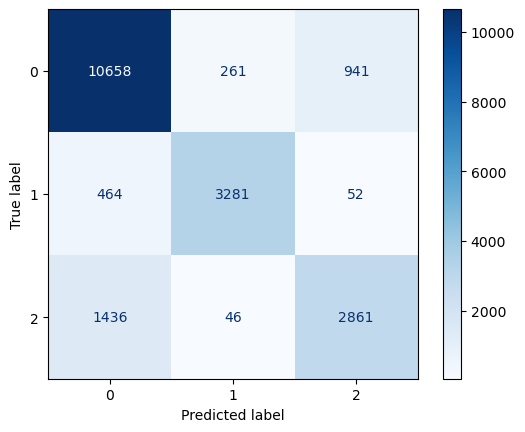

In [40]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                        labels = lr.classes_, cmap = 'Blues')

plt.show()

In [41]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

print(classification_report(y_test, y_pred))

Accuracy: 84.00%
              precision    recall  f1-score   support

           0       0.85      0.90      0.87     11860
           1       0.91      0.86      0.89      3797
           2       0.74      0.66      0.70      4343

    accuracy                           0.84     20000
   macro avg       0.84      0.81      0.82     20000
weighted avg       0.84      0.84      0.84     20000



# Decision Tree

In [43]:
dt = DecisionTreeClassifier(ccp_alpha = 0.0001, criterion = 'entropy', random_state = 42)

dt.fit(x_train, y_train)
y_pred_dt = dt.predict(x_test)

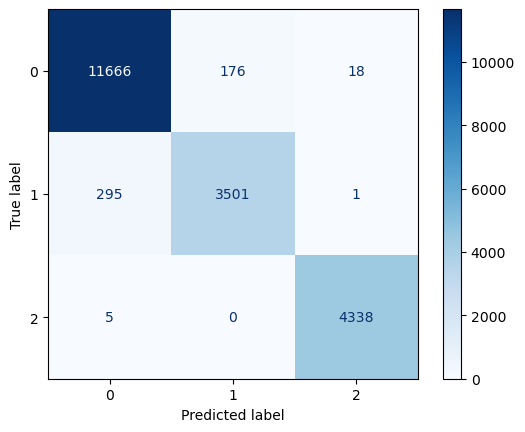

In [44]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dt,
                                        labels = dt.classes_, cmap = 'Blues')

plt.show()

In [45]:
accuracy = accuracy_score(y_test, y_pred_dt)
print(f"Accuracy: {accuracy * 100:.2f}%")

print(classification_report(y_test, y_pred_dt))

Accuracy: 97.52%
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     11860
           1       0.95      0.92      0.94      3797
           2       1.00      1.00      1.00      4343

    accuracy                           0.98     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.98      0.98      0.98     20000



# Random Forest

In [47]:
rf = RandomForestClassifier(random_state=42, n_jobs = -1)
scores = cross_val_score(rf, x, y, cv=5, scoring='accuracy')
print(f"Cross_val_score: {scores.mean() * 100:.2f}% (+/- {scores.std() * 2 * 100:.2f})")

Cross_val_score: 97.88% (+/- 0.14)


In [48]:
rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)

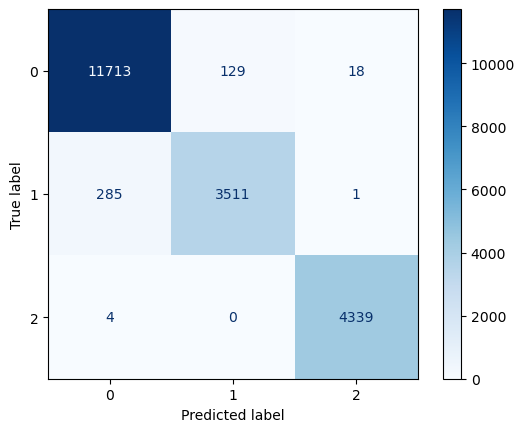

In [49]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf,
                                        labels = rf.classes_, cmap = 'Blues')

plt.show()

In [50]:
accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred_rf))

Accuracy: 97.81%
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     11860
           1       0.96      0.92      0.94      3797
           2       1.00      1.00      1.00      4343

    accuracy                           0.98     20000
   macro avg       0.98      0.97      0.97     20000
weighted avg       0.98      0.98      0.98     20000



# Feature Importance

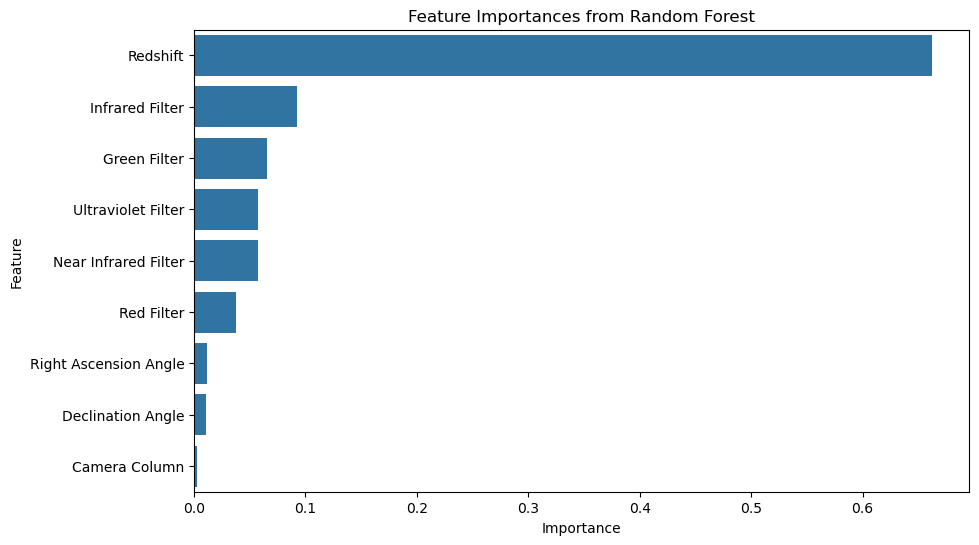

In [52]:
importances = rf.feature_importances_

feature_importances = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances from Random Forest')
plt.show()

as we can see that Camera column is of low importance we can drop that column.

# Bagging

In [55]:
clf_bag = BaggingClassifier(n_estimators=10, random_state=42)

clf_bag.fit(x_train, y_train)
y_pred_bag = clf_bag.predict(x_test)

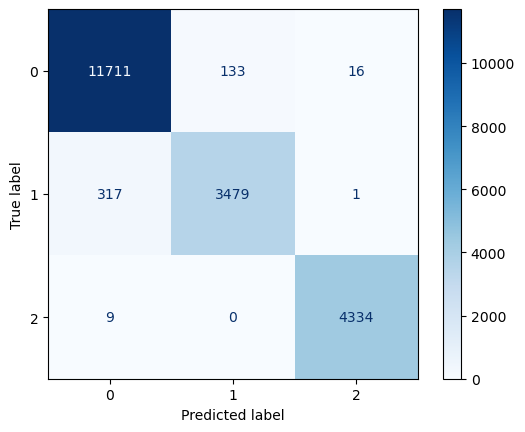

In [56]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_bag,
                                        labels = clf_bag.classes_, cmap = 'Blues')

plt.show()

In [57]:
accuracy = accuracy_score(y_test, y_pred_bag)
print(f"Accuracy: {accuracy * 100:.2f}%")

print(classification_report(y_test, y_pred_bag))

Accuracy: 97.62%
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     11860
           1       0.96      0.92      0.94      3797
           2       1.00      1.00      1.00      4343

    accuracy                           0.98     20000
   macro avg       0.98      0.97      0.97     20000
weighted avg       0.98      0.98      0.98     20000



# KNN

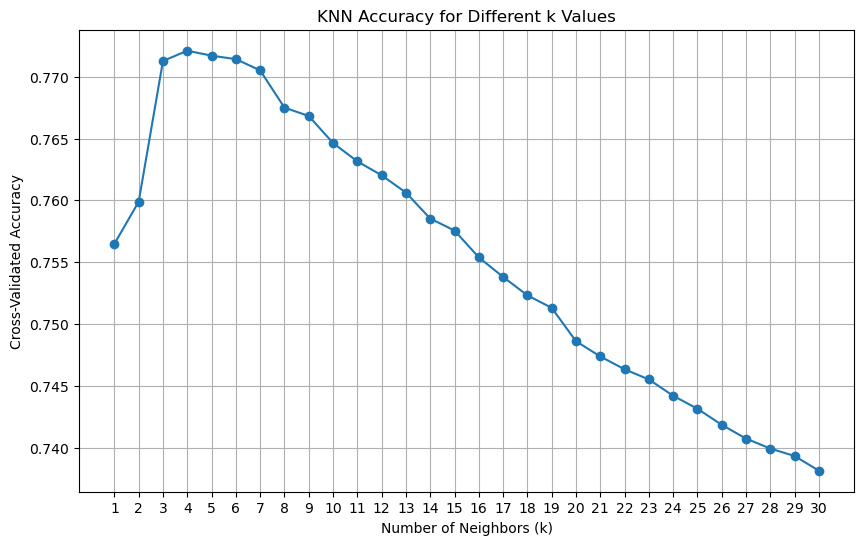

The optimal number of neighbors is 4 with an accuracy of 0.7721.


In [59]:
k_range = range(1, 31)

# Initialize a list to store accuracy scores
accuracies = []

# Loop over different values of k
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    # Use cross-validation to evaluate the model
    scores = cross_val_score(knn, x, y, cv=5, scoring='accuracy')
    # Append mean accuracy to list
    accuracies.append(scores.mean())

# Plot accuracy vs. k
plt.figure(figsize=(10, 6))
plt.plot(k_range, accuracies, marker='o')
plt.title('KNN Accuracy for Different k Values')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validated Accuracy')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Find the k with the highest accuracy
best_k = k_range[accuracies.index(max(accuracies))]
print(f"The optimal number of neighbors is {best_k} with an accuracy of {max(accuracies):.4f}.")

In [60]:
knn_uniform = KNeighborsClassifier(n_neighbors=4, weights='uniform')
knn_distance = KNeighborsClassifier(n_neighbors=4, weights='distance')

# Evaluate using cross-validation
cv_score_uniform = cross_val_score(knn_uniform, x_train, y_train, cv=5, scoring='accuracy')
cv_score_distance = cross_val_score(knn_distance, x_train, y_train, cv=5, scoring='accuracy')

# Fit the models
knn_uniform.fit(x_train, y_train)
knn_distance.fit(x_train, y_train)

# Calculate accuracy on the test set
test_accuracy_uniform = knn_uniform.score(x_test, y_test)
test_accuracy_distance = knn_distance.score(x_test, y_test)

print(f"Uniform Weights - Cross-Validated Accuracy: {cv_score_uniform.mean():.4f}")
print(f"Distance Weights - Cross-Validated Accuracy: {cv_score_distance.mean():.4f}")
print(f"Uniform Weights - Test Accuracy: {test_accuracy_uniform:.4f}")
print(f"Distance Weights - Test Accuracy: {test_accuracy_distance:.4f}")

Uniform Weights - Cross-Validated Accuracy: 0.8217
Distance Weights - Cross-Validated Accuracy: 0.8342
Uniform Weights - Test Accuracy: 0.8243
Distance Weights - Test Accuracy: 0.8390


In [61]:
knn = KNeighborsClassifier(n_neighbors = 4, weights = 'distance')

knn.fit(x_train, y_train)
knn_pred = knn.predict(x_test)

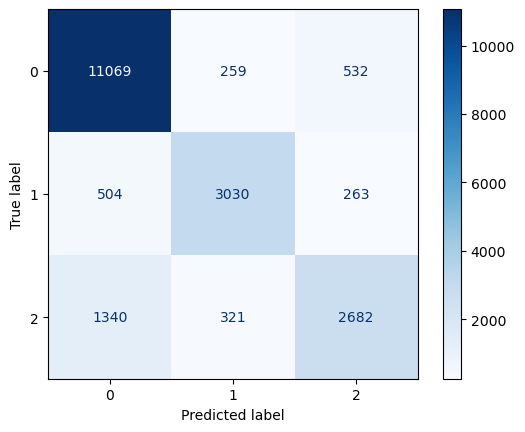

In [62]:
ConfusionMatrixDisplay.from_predictions(y_test, knn_pred,
                                        labels = knn.classes_, cmap = 'Blues')

plt.show()

In [63]:
accuracy = accuracy_score(y_test, knn_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

print(classification_report(y_test, knn_pred))

Accuracy: 83.91%
              precision    recall  f1-score   support

           0       0.86      0.93      0.89     11860
           1       0.84      0.80      0.82      3797
           2       0.77      0.62      0.69      4343

    accuracy                           0.84     20000
   macro avg       0.82      0.78      0.80     20000
weighted avg       0.84      0.84      0.83     20000



# Linear SVM

In [65]:
linear = LinearSVC(C = 1)

linear.fit(x_train, y_train)
linear_pred = linear.predict(x_test)

C:\Users\rahul\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\rahul\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


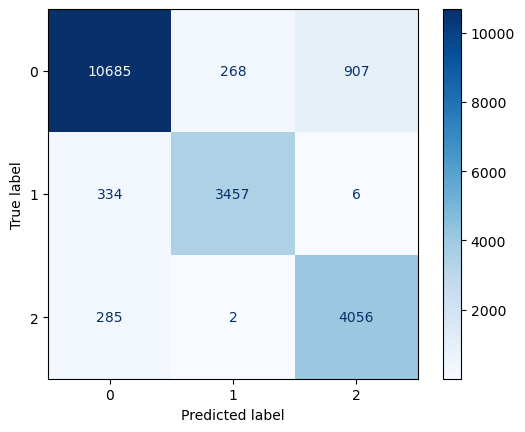

In [66]:
ConfusionMatrixDisplay.from_predictions(y_test, linear_pred,
                                        labels = linear.classes_, cmap = 'Blues')

plt.show()

In [67]:
accuracy = accuracy_score(y_test, linear_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

print(classification_report(y_test, linear_pred))

Accuracy: 90.99%
              precision    recall  f1-score   support

           0       0.95      0.90      0.92     11860
           1       0.93      0.91      0.92      3797
           2       0.82      0.93      0.87      4343

    accuracy                           0.91     20000
   macro avg       0.90      0.92      0.90     20000
weighted avg       0.91      0.91      0.91     20000



# Radial SVM

In [69]:
rbf = SVC(C = 1, kernel = 'rbf')

rbf.fit(x_train, y_train)
rbf_pred = rbf.predict(x_test)

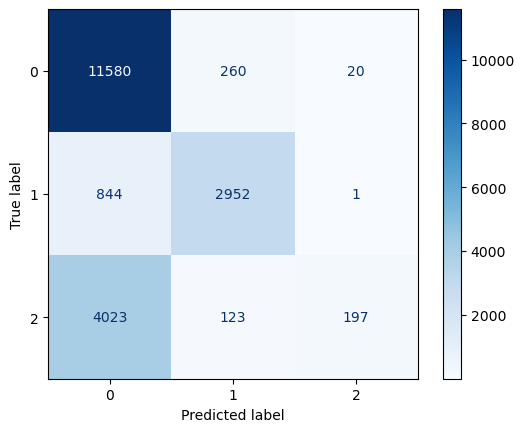

In [70]:
ConfusionMatrixDisplay.from_predictions(y_test, rbf_pred,
                                        labels = rbf.classes_, cmap = 'Blues')

plt.show()

In [71]:
accuracy = accuracy_score(y_test, rbf_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

print(classification_report(y_test, rbf_pred))

Accuracy: 73.65%
              precision    recall  f1-score   support

           0       0.70      0.98      0.82     11860
           1       0.89      0.78      0.83      3797
           2       0.90      0.05      0.09      4343

    accuracy                           0.74     20000
   macro avg       0.83      0.60      0.58     20000
weighted avg       0.78      0.74      0.66     20000



# Gradient Boosting

In [73]:
gb = GradientBoostingClassifier(learning_rate = 0.2, ccp_alpha = 0.0001, random_state = 42, max_depth = 3)

gb.fit(x_train, y_train)
gb_pred = gb.predict(x_test)

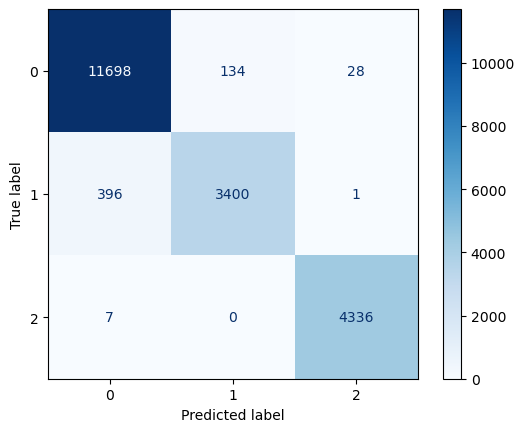

In [74]:
ConfusionMatrixDisplay.from_predictions(y_test, gb_pred,
                                        labels = gb.classes_, cmap = 'Blues')

plt.show()

In [75]:
accuracy = accuracy_score(y_test, gb_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

print(classification_report(y_test, gb_pred))

Accuracy: 97.17%
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     11860
           1       0.96      0.90      0.93      3797
           2       0.99      1.00      1.00      4343

    accuracy                           0.97     20000
   macro avg       0.97      0.96      0.97     20000
weighted avg       0.97      0.97      0.97     20000



# AdaBoost

In [77]:
adaboost = AdaBoostClassifier(algorithm = 'SAMME', learning_rate = 1, n_estimators = 150, random_state = 42)

adaboost.fit(x_train, y_train)
ada_pred = adaboost.predict(x_test)

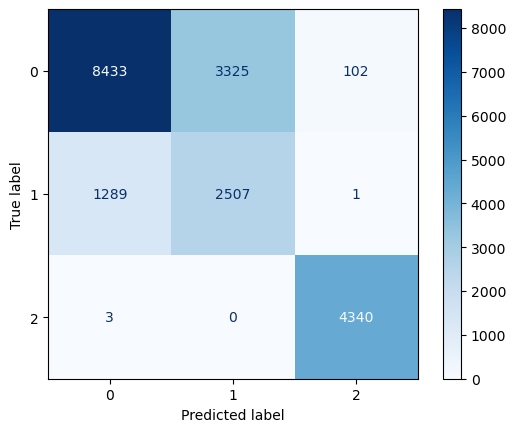

In [78]:
ConfusionMatrixDisplay.from_predictions(y_test, ada_pred,
                                        labels = adaboost.classes_, cmap = 'Blues')

plt.show()

In [79]:
accuracy = accuracy_score(y_test, ada_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

print(classification_report(y_test, ada_pred))

Accuracy: 76.40%
              precision    recall  f1-score   support

           0       0.87      0.71      0.78     11860
           1       0.43      0.66      0.52      3797
           2       0.98      1.00      0.99      4343

    accuracy                           0.76     20000
   macro avg       0.76      0.79      0.76     20000
weighted avg       0.81      0.76      0.78     20000



# XGBoost

In [81]:
XGBoost_clf = xgb.XGBClassifier(objective = 'multi:softprob', learning_rate = 1, random_state = 42)

XGBoost_clf.fit(x_train, y_train)

XGB_predictions = XGBoost_clf.predict(x_test)

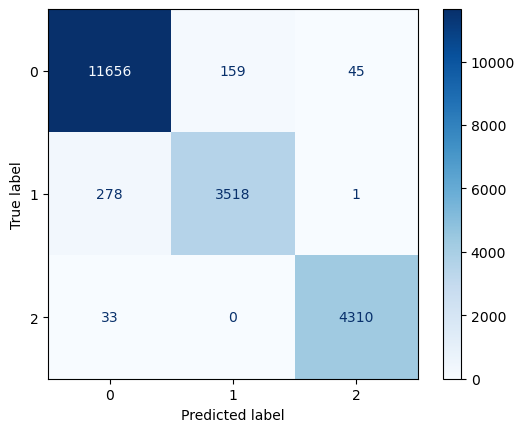

In [82]:
ConfusionMatrixDisplay.from_predictions(y_test, XGB_predictions,
                                        labels = XGBoost_clf.classes_, cmap = 'Blues')

plt.show()

In [83]:
accuracy = accuracy_score(y_test, XGB_predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

print(classification_report(y_test, XGB_predictions))

Accuracy: 97.42%
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     11860
           1       0.96      0.93      0.94      3797
           2       0.99      0.99      0.99      4343

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000



# Accuracy and Model Comparison

In [85]:
Model_Comparison_Table = pd.DataFrame(data = [accuracy_score(y_test, y_pred),
                                              accuracy_score(y_test, y_pred_dt),
                                              accuracy_score(y_test, y_pred_rf),
                                              accuracy_score(y_test, y_pred_bag),
                                              accuracy_score(y_test, knn_pred),
                                              accuracy_score(y_test, linear_pred),
                                              accuracy_score(y_test, rbf_pred),
                                              accuracy_score(y_test, gb_pred),
                                              accuracy_score(y_test, ada_pred),
                                              accuracy_score(y_test, XGB_predictions)],
                                      index = ['Logistic Regression','Decision Tree','Random Forest','Bagging','KNN',
                                               'Linear SVM','Radial SVM','Gradient Boosting','Ada Boost','XGBoost'],
                                      columns = ['Accuracy'])

In [86]:
reports = {
    'Logistic Regression': classification_report(y_test, y_pred, output_dict=True),
    'Decision Tree': classification_report(y_test, y_pred_dt, output_dict=True),
    'Random Forest': classification_report(y_test, y_pred_rf, output_dict=True),
    'Bagging': classification_report(y_test, y_pred_bag, output_dict=True),
    'KNN': classification_report(y_test, knn_pred, output_dict=True),
    'Linear SVM': classification_report(y_test, linear_pred, output_dict=True),
    'Radial SVM': classification_report(y_test, rbf_pred, output_dict=True),
    'Gradient Boosting': classification_report(y_test, gb_pred, output_dict=True),
    'Ada Boost': classification_report(y_test, ada_pred, output_dict=True),
    'XGBoost': classification_report(y_test, XGB_predictions, output_dict=True)
}

# Extract accuracy, precision, recall, and f1-score for each model (from the weighted avg)
metrics = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

for model_name, report in reports.items():
    metrics['Model'].append(model_name)
    metrics['Accuracy'].append(report['accuracy'])  # overall accuracy
    metrics['Precision'].append(report['weighted avg']['precision'])  # weighted precision
    metrics['Recall'].append(report['weighted avg']['recall'])  # weighted recall
    metrics['F1-Score'].append(report['weighted avg']['f1-score'])  # weighted f1-score

# Create a DataFrame
Model_Comparison_Table = pd.DataFrame(metrics)

# Sort the table by accuracy (descending)
Model_Comparison_Table.sort_values(by='Accuracy', ascending=False, inplace=True)

print(Model_Comparison_Table)

                 Model  Accuracy  Precision   Recall  F1-Score
2        Random Forest   0.97815   0.978046  0.97815  0.977997
3              Bagging   0.97620   0.976101  0.97620  0.976007
1        Decision Tree   0.97525   0.975099  0.97525  0.975116
9              XGBoost   0.97420   0.974086  0.97420  0.974085
7    Gradient Boosting   0.97170   0.971610  0.97170  0.971368
5           Linear SVM   0.90990   0.913875  0.90990  0.910698
0  Logistic Regression   0.84000   0.838087  0.84000  0.837943
4                  KNN   0.83905   0.835166  0.83905  0.834200
8            Ada Boost   0.76400   0.807945  0.76400  0.776745
6           Radial SVM   0.73645   0.781798  0.73645  0.661096


In [87]:
Model_Comparison_Table['Accuracy'] = Model_Comparison_Table['Accuracy']

Model_Comparison_Table.sort_values(by = ['Accuracy'], ascending = False)

,Model,Accuracy,Precision,Recall,F1-Score
2,Random Forest,0.97815,0.978046,0.97815,0.977997
3,Bagging,0.97620,0.976101,0.97620,0.976007
1,Decision Tree,0.97525,0.975099,0.97525,0.975116
9,XGBoost,0.97420,0.974086,0.97420,0.974085
7,Gradient Boosting,0.97170,0.971610,0.97170,0.971368
5,Linear SVM,0.90990,0.913875,0.90990,0.910698
0,Logistic Regression,0.84000,0.838087,0.84000,0.837943
4,KNN,0.83905,0.835166,0.83905,0.834200
8,Ada Boost,0.76400,0.807945,0.76400,0.776745
6,Radial SVM,0.73645,0.781798,0.73645,0.661096


In [88]:
metrics_by_class = {
    'Model': [],
    'Class': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

for model_name, report in reports.items():
    for class_label in ['0', '1', '2']:  # Assuming '0' is galaxy, '1' is star, '2' is quasar
        metrics_by_class['Model'].append(model_name)
        metrics_by_class['Class'].append(class_label)  # Replace class_label with actual class names if needed
        metrics_by_class['Precision'].append(report[class_label]['precision'])
        metrics_by_class['Recall'].append(report[class_label]['recall'])
        metrics_by_class['F1-Score'].append(report[class_label]['f1-score'])

# Create a new DataFrame for class-specific metrics
Model_Comparison_By_Class = pd.DataFrame(metrics_by_class)

# Display the updated table
print(Model_Comparison_By_Class)

                  Model Class  Precision    Recall  F1-Score
0   Logistic Regression     0   0.848702  0.898651  0.872963
1   Logistic Regression     1   0.914437  0.864103  0.888558
2   Logistic Regression     2   0.742346  0.658761  0.698060
3         Decision Tree     0   0.974929  0.983642  0.979266
4         Decision Tree     1   0.952135  0.922044  0.936848
5         Decision Tree     2   0.995639  0.998849  0.997241
6         Random Forest     0   0.975921  0.987605  0.981728
7         Random Forest     1   0.964560  0.924677  0.944198
8         Random Forest     2   0.995640  0.999079  0.997357
9               Bagging     0   0.972917  0.987437  0.980123
10              Bagging     1   0.963178  0.916250  0.939128
11              Bagging     2   0.996093  0.997928  0.997009
12                  KNN     0   0.857198  0.933305  0.893634
13                  KNN     1   0.839335  0.797998  0.818145
14                  KNN     2   0.771355  0.617545  0.685934
15           Linear SVM 

# Hyperparameter Tuning the best Model

In [90]:
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

In [91]:
x.columns

Index(['Right Ascension Angle', 'Declination Angle', 'Ultraviolet Filter',
       'Green Filter', 'Red Filter', 'Near Infrared Filter', 'Infrared Filter',
       'Camera Column', 'Redshift'],
      dtype='object')

In [92]:
X = x.drop(['Right Ascension Angle', 'Declination Angle','Camera Column'], axis = 1)
Y = df['Class']

In [93]:
X

,Ultraviolet Filter,Green Filter,Red Filter,Near Infrared Filter,Infrared Filter,Redshift
0,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794
1,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136
2,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195
3,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346
4,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123
...,...,...,...,...,...,...
99995,22.16759,22.97586,21.90404,21.30548,20.73569,0.000000
99996,22.69118,22.38628,20.45003,19.75759,19.41526,0.404895
99997,21.16916,19.26997,18.20428,17.69034,17.35221,0.143366
99998,25.35039,21.63757,19.91386,19.07254,18.62482,0.455040


In [94]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

# GridSearchCV

In [96]:
# Creating a parameter grid dictionary
param_grid_rf = {
    'n_estimators': [100, 200],  
    'max_depth': [None, 10, 20],  
    'min_samples_split': [2, 5],  
    'min_samples_leaf': [1, 2],  
    'max_features': ['log2', 'sqrt']
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, 
                              cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit GridSearchCV
grid_search_rf.fit(X_train, Y_train)

# Print the best parameters and score
print("Best parameters for Random Forest:", grid_search_rf.best_params_)
print("Best cross-validation accuracy for Random Forest:", grid_search_rf.best_score_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best parameters for Random Forest: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy for Random Forest: 0.9785249913994316


*Using the best parameters from the GridSearch to fit the random forest model*

In [98]:
best_params = grid_search_rf.best_params_

# Access specific parameters
max_depth = best_params['max_depth']
max_features = best_params['max_features']
min_samples_leaf = best_params['min_samples_leaf']
min_samples_split = best_params['min_samples_split']
n_estimators = best_params['n_estimators']

In [99]:
print(max_features)

log2


In [100]:
rf_best_param_GCV = RandomForestClassifier(
    max_depth=max_depth,
    max_features=max_features,
    min_samples_leaf=min_samples_leaf,
    min_samples_split=min_samples_split,
    n_estimators=n_estimators,
    random_state=42 
)
rf_best_param_GCV.fit(X_train, Y_train)

y_pred_rf_best_param_GCV = rf_best_param_GCV.predict(X_test)

In [101]:
accuracy = accuracy_score(Y_test, y_pred_rf_best_param_GCV)
print(f"Accuracy: {accuracy * 100:.2f}%")

print(classification_report(Y_test, y_pred_rf_best_param_GCV))

Accuracy: 97.81%
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     11860
           1       0.97      0.92      0.94      3797
           2       1.00      1.00      1.00      4343

    accuracy                           0.98     20000
   macro avg       0.98      0.97      0.97     20000
weighted avg       0.98      0.98      0.98     20000



# RandomsearchCV

In [103]:
param_dist_rf = {
    'n_estimators': randint(100, 300),  # Reduced upper limit
    'max_depth': [None] + list(range(10, 41, 10)),  # Reduced range
    'min_samples_split': randint(2, 10),  # Reduced upper limit
    'min_samples_leaf': randint(1, 3),  # Reduced upper limit
    'max_features': ['sqrt', 'log2']  # Reduced options
}
# Initialize RandomizedSearchCV
random_search_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist_rf,
                                      n_iter=50, cv=3, n_jobs=-1, verbose=2, random_state=42, scoring='accuracy')

# Fit RandomizedSearchCV
random_search_rf.fit(X_train, Y_train)

# Print the best parameters and score
print("Best parameters for Random Forest:", random_search_rf.best_params_)
print("Best cross-validation accuracy for Random Forest:", random_search_rf.best_score_)



Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters for Random Forest: {'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 242}
Best cross-validation accuracy for Random Forest: 0.9785124924931913


In [104]:
best_params_ = random_search_rf.best_params_

# Access specific parameters
max_depth_ = best_params_['max_depth']
max_features_ = best_params_['max_features']
min_samples_leaf_ = best_params_['min_samples_leaf']
min_samples_split_ = best_params_['min_samples_split']
n_estimators_ = best_params_['n_estimators']

In [105]:
print(max_features_)

sqrt


In [106]:
rf_best_param_RCV = RandomForestClassifier(
    max_depth=max_depth_,
    max_features=max_features_,
    min_samples_leaf=min_samples_leaf_,
    min_samples_split=min_samples_split_,
    n_estimators=n_estimators_,
    random_state=42 
)

rf_best_param_RCV.fit(X_train, Y_train)

y_pred_rf_best_param_RCV = rf_best_param_RCV.predict(X_test)

In [107]:
accuracy = accuracy_score(Y_test, y_pred_rf_best_param_RCV)
print(f"Accuracy: {accuracy * 100:.2f}%")

print(classification_report(Y_test, y_pred_rf_best_param_RCV))

Accuracy: 97.81%
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     11860
           1       0.97      0.92      0.94      3797
           2       1.00      1.00      1.00      4343

    accuracy                           0.98     20000
   macro avg       0.98      0.97      0.97     20000
weighted avg       0.98      0.98      0.98     20000



# Final Model

In [109]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [209]:
from collections import Counter

print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_resampled))

Before SMOTE: Counter({0: 47585, 2: 17251, 1: 15164})
After SMOTE: Counter({0: 47585, 2: 47585, 1: 47585})


In [211]:
clf = RandomForestClassifier()

clf.fit(X_train_resampled, y_train_resampled)

final_pred = clf.predict(X_test)

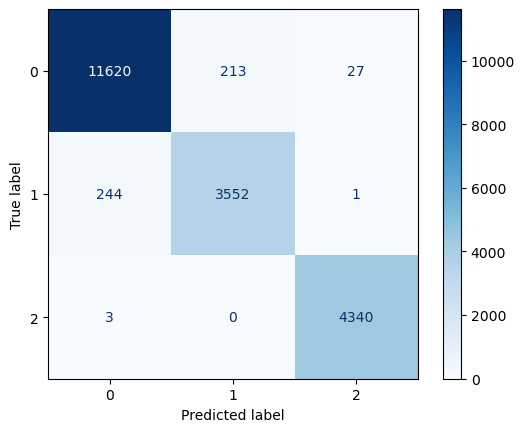

In [212]:
ConfusionMatrixDisplay.from_predictions(y_test, final_pred,
                                        labels = clf.classes_, cmap = 'Blues')

plt.show()

In [213]:
accuracy = accuracy_score(y_test, final_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, final_pred))

Accuracy: 97.56%
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     11860
           1       0.94      0.94      0.94      3797
           2       0.99      1.00      1.00      4343

    accuracy                           0.98     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.98      0.98      0.98     20000



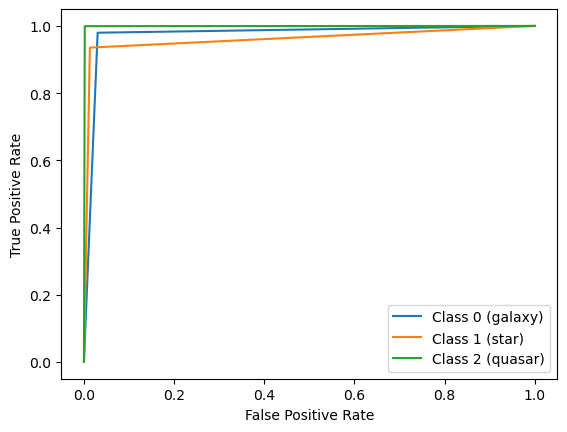

In [217]:
from sklearn.metrics import roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Binarize the output
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # Adjust class labels as needed
y_pred_bin = label_binarize(final_pred, classes=[0, 1, 2])

# For each class
fpr = dict()
tpr = dict()
for i in range(3):  # n_classes is 3 in your case
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])

# Plot the ROC curve for each class
plt.plot(fpr[0], tpr[0], label="Class 0 (galaxy)")
plt.plot(fpr[1], tpr[1], label="Class 1 (star)")
plt.plot(fpr[2], tpr[2], label="Class 2 (quasar)")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="best")
plt.show()


In [219]:
auc_score = roc_auc_score(y_test_bin, y_pred_bin, average="weighted")
print("Weighted ROC AUC Score:", auc_score)

Weighted ROC AUC Score: 0.9773609842072385


# Runtime

In [114]:
# record end time
end = time.time()
 
# print the difference between start 
# and end time in milli. secs
print("The time of execution of above program is :",
      (end-start) * 10**3, "ms")

The time of execution of above program is : 1782326.5480995178 ms
